In [1]:
import os

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from scripts.get_root import PROJECT_ROOT

from src.utils_performance import (
    _all_algorithms_all_datasets_performance,
)

from src.utils_visualization import NotebookFigureSaver
from src.utils_data_centric import _get_all_data_set_characteristics

# Where to save the figures
CHAPTER_ID = "g_uncertainty_estimation"
fig_saver = NotebookFigureSaver(CHAPTER_ID)

# %%
# get the characteristic statistics on all data sets
normalized_data_set_characteristics = _get_all_data_set_characteristics(
    multivariate=False, number_data_sets=None, normalize_each_characteristic=True
)
X = pd.DataFrame(normalized_data_set_characteristics)

# get the mean performance of all algorithms on all data sets
algorithm_data_set_performance = _all_algorithms_all_datasets_performance(
    performance_of_interest="$\\hat{\\mu}$", multivariate=False
)
Y = pd.DataFrame(algorithm_data_set_performance).T

# inner join x and y on index
matched_data_sets = X.join(Y, how="inner")
# document how many rows were not matched
num_rows_not_matched = len(X) - len(matched_data_sets)
print(f"Number of rows not matched: {num_rows_not_matched} from total of {len(X)}")

# %%
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

Number of rows not matched: 12 from total of 124


In [3]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF


def _run_and_plot_gaussian_process(
    applied_algorithm=Y.columns[0],
    feature_dimension="$||x_{train}^{i}||$",
    lower_scale_choice=3,
    upper_scale_choice=3,
    length_scale=0.5,
    alpha=1.0,
    n_restarts_optimizer=0,
    logic_clip=False,
):
    # set the length scale bounds by the power of 10
    length_scale_lower_bound=10**-upper_scale_choice
    length_scale_upper_bound=10**lower_scale_choice
    length_scale_bounds = (length_scale_lower_bound, length_scale_upper_bound)

    # create the gaussian process
    gaussian_process = GaussianProcessRegressor(
        kernel=1
        * RBF(length_scale=length_scale, length_scale_bounds=length_scale_bounds),
        alpha=alpha,
        n_restarts_optimizer=n_restarts_optimizer,
    )

    # split the data
    X_train, X_test, y_train, y_test = train_test_split(
        matched_data_sets[[feature_dimension]],
        matched_data_sets[applied_algorithm],
        test_size=0.3,
        random_state=42,
    )

    # fit the gaussian process
    gaussian_process.fit(X_train, y_train)

    # plot the train and test points
    plt.scatter(X_train, y_train, label="Train")
    plt.scatter(X_test, y_test, label="Test")

    # get predictions for the whole range of X
    X_to_predict = np.linspace(start=0, stop=1, num=1_000).reshape(-1, 1)
    mean_prediction, std_prediction = gaussian_process.predict(
        X_to_predict, return_std=True
    )
    
    # clip the mean prediction between 0 and 1 if configured
    if logic_clip:
        mean_prediction = np.clip(mean_prediction, 0, 1)
    plt.plot(X_to_predict, mean_prediction, label="Mean prediction")

    # calculate the upper and lower confidence
    upper_confidence = mean_prediction + 1.96 * std_prediction
    lower_confidence = mean_prediction - 1.96 * std_prediction

    # clip upper and lower confidence between 0 and 1
    if logic_clip:
        upper_confidence = np.clip(upper_confidence, 0, 1)
        lower_confidence = np.clip(lower_confidence, 0, 1)

    # plot the confidence interval
    plt.fill_between(
        X_to_predict.flatten(),
        upper_confidence,
        lower_confidence,
        alpha=0.5,
        label=r"95% confidence interval",
    )
    plt.legend()

/Users/larsboecking/Documents/01_Code/data_centric_ts/.venv/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GaussianProcessRegressor was fitted with feature names
  warnings.warn(


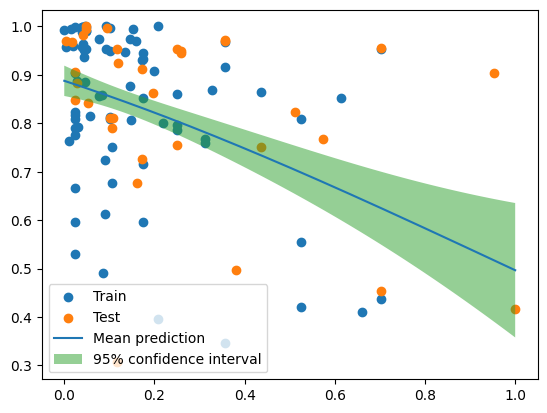

In [4]:
_run_and_plot_gaussian_process(
    applied_algorithm=Y.columns[0],
    feature_dimension="$||x_{train}^{i}||$",
    lower_scale_choice=3,
    upper_scale_choice=3,
    length_scale=1.,
    alpha=.01,
    n_restarts_optimizer=0,
    logic_clip=False,
)

In [5]:
# use python interact to make the plot interactive
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from ipywidgets.widgets import IntSlider, FloatSlider

interact(
    _run_and_plot_gaussian_process,
    applied_algorithm=Y.columns,
    feature_dimension=X.columns,
    lower_scale_choice=IntSlider(min=0, max=10, step=1, value=1),
    upper_scale_choice=IntSlider(min=0, max=10, step=1, value=1),
    length_scale=FloatSlider(min=0.0, max=1.0, step=0.01, value=1.0),
    alpha=FloatSlider(min=0.0, max=0.1, step=0.001, value=0.01),
    n_restarts_optimizer=IntSlider(min=0, max=30, step=1, value=0),
    logic_clip = [True,False],
)

interactive(children=(Dropdown(description='applied_algorithm', options=('ResNet_ACC', '1NN-DTW_ACC', 'EE_ACC'…

<function __main__._run_and_plot_gaussian_process(applied_algorithm='ResNet_ACC', feature_dimension='$||x_{train}^{i}||$', lower_scale_choice=3, upper_scale_choice=3, length_scale=0.5, alpha=1.0, n_restarts_optimizer=0, logic_clip=False)>

In [23]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error


def evaluate_model(model, X_train, X_val, X_test, y_train, y_val, y_test):

    # Fit the model on the training data
    model.fit(X_train, y_train)

    # Predict on the validation set
    y_pred_val = model.predict(X_val)
    mae_val = mean_absolute_error(y_val, y_pred_val)
    mse_val = mean_squared_error(y_val, y_pred_val)

    # Predict on the test set
    y_pred_test = model.predict(X_test)
    mae_test = mean_absolute_error(y_test, y_pred_test)
    mse_test = mean_squared_error(y_test, y_pred_test)

    # Naive baseline performance for validation and test
    naive_baseline_val = np.repeat(y_train.mean(), len(y_val))
    naive_baseline_test = np.repeat(y_train.mean(), len(y_test))

    mae_naive_val = mean_absolute_error(naive_baseline_val, y_val)
    mse_naive_val = mean_squared_error(naive_baseline_val, y_val)
    mae_naive_test = mean_absolute_error(naive_baseline_test, y_test)
    mse_naive_test = mean_squared_error(naive_baseline_test, y_test)

    # Calculate relative improvement for validation and test for both MAE and MSE
    relative_improvement_mae_val = (mae_val - mae_naive_val) / mae_naive_val
    relative_improvement_mse_val = (mse_val - mse_naive_val) / mse_naive_val
    relative_improvement_mae_test = (mae_test - mae_naive_test) / mae_naive_test
    relative_improvement_mse_test = (mse_test - mse_naive_test) / mse_naive_test

    results_dict = {
        "Validation": {
            "raw_predictions": {
                "GT Performance": y_val,
                "Estimated Performance": y_pred_val,
                "Naive Baseline": naive_baseline_val,
            },
            "metrics":{
                "Naive MAE": mae_naive_val,
                "Naive MSE": mse_naive_val,
                "Model MAE": mae_val,
                "Model MSE": mse_val,
                "Improvement MAE": relative_improvement_mae_val,
                "Improvement MSE": relative_improvement_mse_val,
            },
        },
        "Test": {
            "raw_predictions": {
                "GT Performance": y_test,
                "Estimated Performance": y_pred_test,
                "Naive Baseline": naive_baseline_test,
            },
            "metrics":{
                "Naive MAE": mae_naive_test,
                "Naive MSE": mse_naive_test,
                "Model MAE": mae_test,
                "Model MSE": mse_test,
                "Improvement MAE": relative_improvement_mae_test,
                "Improvement MSE": relative_improvement_mse_test,
            }
        }
    }
    
    return results_dict

def _run_and_plot(
applied_algorithm=Y.columns[0],
lower_scale_choice=3,
upper_scale_choice=3,
length_scale=0.5,
alpha=1.0,
n_restarts_optimizer=0,
test_size = 0.25,
validation_size = 0.25 
):
    # set the length scale bounds by the power of 10
    length_scale_lower_bound = 10**-upper_scale_choice
    length_scale_upper_bound = 10**lower_scale_choice
    length_scale_bounds = (length_scale_lower_bound, length_scale_upper_bound)

    # create the gaussian process
    model = GaussianProcessRegressor(
        kernel=1
        * RBF(length_scale=length_scale, length_scale_bounds=length_scale_bounds),
        alpha=alpha,
        n_restarts_optimizer=n_restarts_optimizer,
    )

    X_train_val, X_test, y_train_val, y_test = train_test_split(
        matched_data_sets[X.columns],
        matched_data_sets[applied_algorithm],
        test_size=test_size,
        random_state=42,
    )
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=validation_size, random_state=42)

    results_dict = evaluate_model(model, X_train, X_val, X_test, y_train, y_val, y_test)

    # Extract metrics for easy access
    val_metrics = results_dict["Validation"]["metrics"]
    test_metrics = results_dict["Test"]["metrics"]

    # Print statements for validation and test metrics along with relative improvements
    print(f"Validation - MAE: {val_metrics['Model MAE']:.3f}, MSE: {val_metrics['Model MSE']:.3f} "
          f"[Improvement MAE: {val_metrics['Improvement MAE'] * 100:.2f}%, "
          f"Improvement MSE: {val_metrics['Improvement MSE'] * 100:.2f}%]")

    print(f"Test - MAE: {test_metrics['Model MAE']:.3f}, MSE: {test_metrics['Model MSE']:.3f} "
          f"[Improvement MAE: {test_metrics['Improvement MAE'] * 100:.2f}%, "
          f"Improvement MSE: {test_metrics['Improvement MSE'] * 100:.2f}%]")


    fig_size = (10, 4)
    fig, ax = plt.subplots(1, 1, figsize=fig_size, sharex=False, sharey=True)
    gt_performance = results_dict["Test"]['raw_predictions']["GT Performance"].values
    estimated_performance = results_dict["Test"]['raw_predictions']["Estimated Performance"]
    naive_baseline = results_dict["Test"]['raw_predictions']["Naive Baseline"]

    plt.scatter(
        gt_performance,
        estimated_performance,
        label="Predicted $\mathbb{E}_{h}^{d}$",
        s=100,
        alpha=0.7,
    )
    plt.plot(
        [
            results_dict["Test"]['raw_predictions']["GT Performance"].values.min(),
            results_dict["Test"]['raw_predictions']["GT Performance"].values.max(),
        ],
        [
            results_dict["Test"]['raw_predictions']["Naive Baseline"].max(),
            results_dict["Test"]['raw_predictions']["Naive Baseline"].min(),
        ],
        linestyle="--",
        color="orange",
        label="Naive Baseline $\mathbb{E}_{h}^{d}$",
    )
    # Plot the perfect prediction line
    plt.plot(
        [gt_performance.min(), gt_performance.max()],
        [gt_performance.min(), gt_performance.max()],
        "k--",
        label="GT $\mathbb{E}_{h}^{d}$",
    )

    # Adding error bars
    for i in range(len(gt_performance)):
        if np.abs(gt_performance[i] - estimated_performance[i]) < np.abs(
            gt_performance[i] - naive_baseline[i]
        ):
            # Model is better than naive baseline
            plt.vlines(
                gt_performance[i],
                ymin=estimated_performance[i],
                ymax=naive_baseline[i],
                color="green",
                linewidth=4,
                alpha=0.7,
                linestyles="dotted",
            )
        elif np.abs(gt_performance[i] - estimated_performance[i]) > np.abs(
            gt_performance[i] - naive_baseline[i]
        ):
            # Model is worse than naive baseline
            plt.vlines(
                gt_performance[i],
                ymin=naive_baseline[i],
                ymax=estimated_performance[i],
                color="red",
                alpha=0.7,
                linewidth=4,
                linestyles="dotted",
            )

    plt.xlabel("Ground Truth", fontsize=18)
    plt.ylabel("Estimated", fontsize=18)
    ax.tick_params(axis="x", labelsize=18)
    ax.tick_params(axis="y", labelsize=18)
    plt.legend(fontsize=18)
    plt.subplots_adjust(
        hspace=0.5, wspace=0.05, left=0.08, right=0.99, bottom=0.15, top=0.99
    )
    plt.show()

/Users/larsboecking/Documents/01_Code/data_centric_ts/.venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:285: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))


Validation - MAE: 0.110, MSE: 0.019 [Improvement MAE: 0.01%, Improvement MSE: 0.05%]
Test - MAE: 0.132, MSE: 0.031 [Improvement MAE: 0.04%, Improvement MSE: 0.01%]


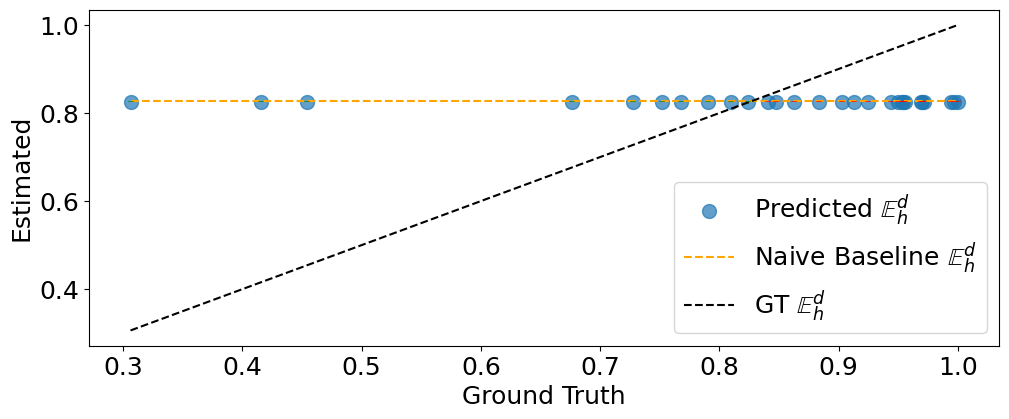

In [24]:
_run_and_plot(
    applied_algorithm=Y.columns[0],
    lower_scale_choice=10,
    upper_scale_choice=10,
    length_scale=0.0,
    alpha=0.01,
    n_restarts_optimizer=5,
    test_size = 0.25,
    validation_size = 0.25 
)

In [25]:
# use python interact to make the plot interactive
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from ipywidgets.widgets import IntSlider, FloatSlider

interact(
    _run_and_plot,
    applied_algorithm=Y.columns,
    lower_scale_choice=IntSlider(min=0, max=10, step=1, value=10),
    upper_scale_choice=IntSlider(min=0, max=10, step=1, value=10),
    length_scale=FloatSlider(min=0.0, max=1.0, step=0.01, value=0.),
    alpha=FloatSlider(min=0.0, max=0.1, step=0.001, value=0.01),
    n_restarts_optimizer=IntSlider(min=0, max=30, step=1, value=5),
    test_size=FloatSlider(min=0.05, max=1., step=0.05, value=0.25),
    validation_size=FloatSlider(min=0.05, max=1., step=0.05, value=0.25),
)

interactive(children=(Dropdown(description='applied_algorithm', options=('ResNet_ACC', '1NN-DTW_ACC', 'EE_ACC'…

<function __main__._run_and_plot(applied_algorithm='ResNet_ACC', lower_scale_choice=3, upper_scale_choice=3, length_scale=0.5, alpha=1.0, n_restarts_optimizer=0, test_size=0.25, validation_size=0.25)>